In [ ]:
df = pd.read_csv('/content/data (3).csv')
df1 = pd.read_csv('/content/data (1).csv')
df2 = pd.read_csv('/content/data (2).csv')
r = [df,df1,df2]
df = pd.concat(r)
df.drop(['product_link','web-scraper-start-url','product_link-href','web-scraper-order','reviews-href'],axis=1,inplace=True)#

## Pre-processing

**Data Preprocessing**

1. Creating a Serial Indexing for products
2. Extracting Retail and Rental Price
3. Converting height column from string to numeric in inches
4. Variable type conversions (e.g. datetype, int etc)
5. Data Imputation using mean method
6. Resolve Scraping issues (eg Bust Size contains bodytype) 
7. Understanid products with no reviews and looking for some similarity
8. Splitting Data into meaningful information (Product Info)
9. Running Topic Modeling to observe which clothes are not selected and do they have any similarities 







## Key Insights

**1. According to occasions, Weddings has the most diverse range with respect to the rental prices which is justified since during the inception of the company, major attraction was weddings and parties**

**2. We observe products following a linear relationship between retail and rental price. Most of our producte lie in the retail in greater or less than 250 dollars and rental in less than 50 dollars**

##No_reviews Data Analysis

**1. 96 products have no reviews. Out of no review products, 86% are imported**

**2. Most of these clothes are made of polyester or cotton and are either printed or floral, are wrap dresses or tops/skirts with zippers**

**3. We don't see any correlation between no_reviews items - not liked by a lot and rental and retail prices**



In [ ]:
key = df['product_name'].drop_duplicates().reset_index()
key.columns=['Serial','Name']
key['Serial'] = key['Serial'] +1 
df = df.merge(key,how='left',left_on='product_name',right_on = 'Name')
df['product_rental_price'] = df['product_rental_ptice'] 
no_review_data = df[(df['reviews'].isnull())][['product_name','product_brand','product_retail_price','product_rental_price','Product Info']]
df.drop(['Name','product_rental_ptice','Body Type'],axis=1,inplace=True)

In [ ]:
df.head(4)
df.shape,df.drop_duplicates().shape
df.dtypes

extract_letter(df,'product_retail_price','[0-9]',1)
extract_letter(df,'product_rental_price','\D',2)

df['Review Date'] = df['Review Date'].str.replace(',',' ')
df['Review Date'] = pd.to_datetime(df['Review Date'])

df['Height']= df['Height'].str[0].astype(float)*12 +  df['Height'].str[3].astype(float)
df['Height'] = df['Height'].fillna(int(df['Height'].mean())).astype(float)

df['Weight']= df['Weight'].str[0:-3].fillna('0')
df['Weight'].apply(lambda x: x.split('.')[0])

pattern1 = re.compile(r'[0-9][0-9][\w+]',re.I)
df['Bust Size'] = np.where(df['Bust Size'].str.contains(pattern1), df['Bust Size'],0)

df['Stylist Info'] = extract_string(df['Product Info'],'Notes','Size')
df['Size Info'] = extract_string(df['Product Info'],'Sized:','.Product')
df['Product Details'] = extract_string(df['Product Info'],'Details','ShareSave')

pattern3 = 'Imported'
df['Imported/USA'] = np.where(df['Product Details'].str.contains(pattern3), pattern3,'USA')

pattern4 = '"'
df['Size_worn'] = np.where(df['Size_worn'].str.contains(pattern4),0,df['Size_worn'])

pattern5 = re.compile(r'[\w+]',re.I)
df['Bust Size'] = np.where((df['Bust Size']==0) & (df['Age'].str.contains(pattern5)),df['Age'],df['Bust Size'])

pattern6 = re.compile(r'[a-zA-Z]+',re.I)
df['Age'] = np.where(df['Age'].str.contains(pattern6),0,df['Age'])

df['Age'] = df['Age'].apply(lambda x: int(x))
df['Size_worn'] = df['Size_worn'].apply(lambda x: int(x))

df['Weight']= df['Weight'].replace(r'^\s*$', np.nan, regex=True)
df['Weight'] = np.where(pd.notnull(df['Weight']),df['Weight'],0)
df['Weight']
df['Weight'] = df['Weight'].apply(lambda x: int(x))

df.head(4)
df.dtypes

**Top 10 reviewed products**

In [ ]:
df['product_name'].value_counts().head(10)

**Occasion Analysis**

In [ ]:
df['Occasion '].value_counts()

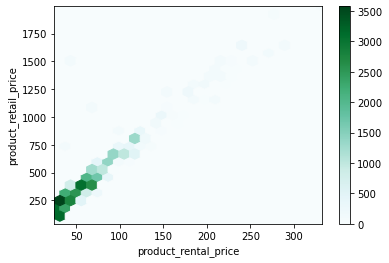

In [ ]:
df.plot.hexbin(x='product_rental_price',y='product_retail_price',gridsize=25,cmap='',sharex=False).autoscale(enable=True, tight=True, axis='both');

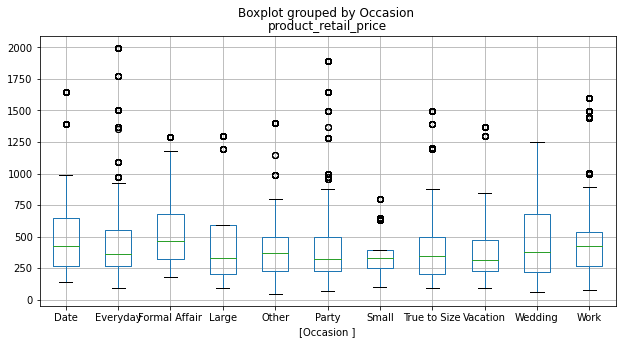

In [ ]:
df_edited = df[(df['Occasion ']!='Small') | (df['Occasion ']!='Large') | (df['Occasion ']!='True to Size')]
df_edited[['Occasion ','product_retail_price']].boxplot(by='Occasion ', grid=True,figsize=(10,5));

## **No Review Data Analysis**

In [ ]:
no_review_data = df[(df['reviews'].isnull())][['Serial','product_name','product_brand','product_retail_price','product_rental_price','Stylist Info','Product Details','Imported/USA']]
df.drop(['reviews'],axis=1,inplace=True)
no_review_data
concat_data(no_review_data,'Serial')

embed_review_data = USE_embed(no_review_data,'all')
embed_review_data['Serial'] = no_review_data['Serial'].to_numpy()
embed_review_data = embed_review_data.T
embed_review_data.columns = embed_review_data.iloc[-1]
corr = embed_review_data.corr()
no_review_data['Imported/USA'].value_counts(normalize=True)*100
#no_review_data.groupby(['Imported/USA','product_brand']).agg({'Serial':'count','product_retail_price':'mean','product_rental_price':'mean'}).reset_index()

Imported    85.294118
USA         14.705882
Name: Imported/USA, dtype: float64

In [ ]:
No_rev_analysis = no_review_data.groupby('product_brand').agg({'product_rental_price':'mean','product_retail_price':'mean'}).reset_index()
No_rev_analysis['Percent'] = No_rev_analysis['product_rental_price']/No_rev_analysis['product_retail_price']*100
No_rev_analysis.sort_values(by='Percent',ascending=False).head(5)

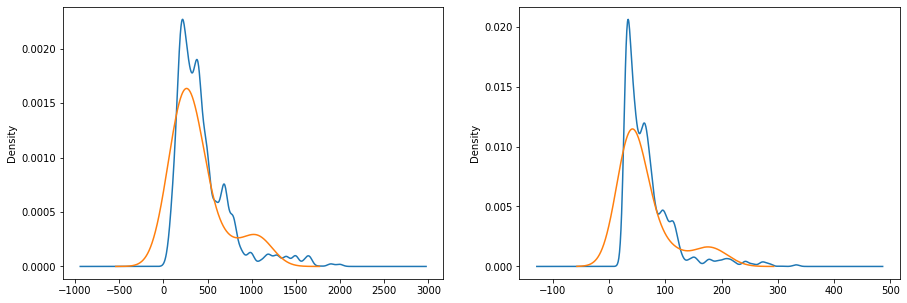

In [ ]:
figure, axes = plt.subplots(1, 2)
df['product_retail_price'].plot.kde(figsize=(15,5),ax=axes[0])
no_review_data['product_retail_price'].plot.kde(ax=axes[0])
df['product_rental_price'].plot.kde(figsize=(15,5),ax=axes[1])
no_review_data['product_rental_price'].plot.kde(ax=axes[1])

In [ ]:
warnings.filterwarnings("ignore")
print(list(review_tagger(no_review_data,'Stylist Info',20)['index'].values))
print(list(review_tagger(no_review_data,'Product Details',10)['index'].values))

['trend', 'lend', 'high', 'trendy', 'size']
['hemline', 'closure', 'hide', 'sleeve', 'import']


In [ ]:
list(review_tagger(no_review_data,'Product Details',10)['index'].values)

#### Our review tagger is implemented

## Applications
1. Reduce conversion time by allowing users the appropriate subset of reviews
2. Segment reviews over time to understand different customer segments


## Functions

In [ ]:
!pip install unidecode
import pandas as pd
import numpy as np
import re
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import re
from re import sub
import multiprocessing
from unidecode import unidecode

import nltk
nltk.download('all')
!pip install pyLDAvis
from pprint import pprint
# NLTK 
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english') #this depends on each language
# Gensim
!pip install gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from time import time 
from collections import defaultdict

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [ ]:
def review_tagger(dataframe,column,n):
  info = dataframe[column].tolist()
  info = map(preprocess,info)
  a = ldafunc(info,n)
  first = []
  for i in np.arange(1,10):
    [first.append(i[0]) for i in a[i][1]]
  return pd.Series(first).value_counts().reset_index().iloc[:5,:1]

In [ ]:
def extract_letter(df,col,regex,a):
  if a ==1 :
    df[col] = df[col].apply(lambda x: float(''.join(re.findall(regex, x))))
  elif a == 2:
    df[col] = df[col].apply(lambda x: statistics.mean(map(int,re.sub(regex,' ',x).strip().split())))

def extract_string(df,start,end):
  start = start
  end = end
  return df.apply(lambda s :s[s.find(start)+len(start):s.rfind(end)])

def concat_data(df,dontadd):
  df['all'] = df.loc[:,df.columns != dontadd].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)

def USE_embed(df,col):
  data_ls = df[col].tolist()
  b = embed(data_ls)
  b = b.numpy()
  return(pd.DataFrame(b))

In [ ]:
%%capture
# Install the latest Tensorflow version.
!pip3 install --upgrade tensorflow-gpu
# Install TF-Hub.
!pip3 install tensorflow-hub
!pip3 install seaborn
#@title Load the Universal Sentence Encoder's TF Hub module
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

In [ ]:
def ldafunc(data,n):
  def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

  data_words = list(sent_to_words(data))

  #print(data_words[:1])
  # Build the bigram and trigram models
  bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
  trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

  # Faster way to get a sentence clubbed as a trigram/bigram
  bigram_mod = gensim.models.phrases.Phraser(bigram)
  trigram_mod = gensim.models.phrases.Phraser(trigram)

  # See trigram example
  #print(trigram_mod[bigram_mod[data_words[0]]])
  # Define functions for stopwords, bigrams, trigrams and lemmatization
  def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

  def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

  def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

  def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out 
  #To run this code it is necessary to get the spacy moidel: "!python - m spacy download en", last depends on the used language 

  # Remove Stop Words
  data_words_nostops = remove_stopwords(data_words)

  # Form Bigrams
  data_words_bigrams = make_bigrams(data_words_nostops)

  # Initialize spacy 'es' model, keeping only tagger component (for efficiency)
  #python3 -m spacy download es
  nlp = spacy.load('en', disable=['parser', 'ner'])

  # Do lemmatization keeping only noun, adj, vb, adv
  data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

  # Create Dictionary
  id2word = corpora.Dictionary(data_lemmatized)

  # Create Corpus
  texts = data_lemmatized

  # Term Document Frequency
  corpus = [id2word.doc2bow(text) for text in texts]

  # View
  #print(corpus[:1])
  # Human readable format of corpus (term-frequency)
  [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

  # Build LDA model
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=14,
                                           alpha='auto',
                                           per_word_topics=False)
  #pprint(lda_model.print_topics())
  doc_lda = lda_model[corpus]

  # Visualize the topics
  pyLDAvis.enable_notebook()
  vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
  vis

  return lda_model.show_topics(formatted=False, num_words=20)

In [ ]:
def text_to_word_list(text):
    text = str(text)
    text = text.lower()

    # Clean the text
    text = sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)
    text = sub(r"\+", " plus ", text)
    text = sub(r",", " ", text)
    text = sub(r"\.", " ", text)
    text = sub(r"!", " ! ", text)
    text = sub(r"\?", " ? ", text)
    text = sub(r"'", " ", text)
    text = sub(r":", " : ", text)
    text = sub(r"\s{2,}", " ", text)


    text = text.split()
    return text

def preprocess(pdf):
  custom_spec_list = ['size','fit','top','print']
  for i in custom_spec_list:
    pdf=pdf.replace(i,' ')
  return pdf

In [ ]:
def matrix(df):
  ind = df.index.to_list()
  a = len(ind)
  data = pd.DataFrame(np.zeros((a,a)),columns=ind,index=ind)
  return data

